Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [32]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
#!unzip /content/gdrive/MyDrive/Upgrad/CNN_assignment.zip -d /content/gdrive/MyDrive/Upgrad/ANN_assignment

Archive:  /content/gdrive/MyDrive/Upgrad/CNN_assignment.zip
  inflating: /content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split=0.2,
    subset= 'training',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split = 0.2,
    subset = 'validation',
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

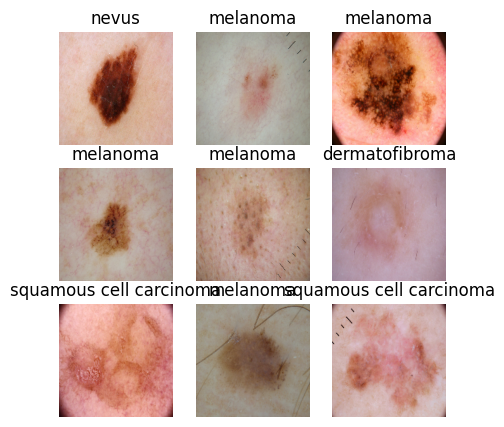

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize = (5,5))
for images, labels in train_ds.take(5):
  for i in range(9):
    ax= plt.subplot(3,3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
num_classes = 9
#A sequentional model is appropiate for a pain stack of layers where each layer has exactly on einput tensor
#and one out put tensor
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height,img_width,3)),
    #2D convolutaional layer(e.g spatial convolution over images)
    layers.Conv2D(16,3,padding='same',activation='relu'),

    #we slide over the feature maps and extract files of a specific size
    #Downsize teh input along its spatial dimentions(height, width) by taking the maximum value over an input window
    layers.MaxPooling2D(),

    #we slide over the feature maps and extract files of a specific size
    layers.Conv2D(32,3,padding='same', activation='relu'),

    layers.MaxPooling2D(),

    layers.Conv2D(64,3,padding='same', activation='relu'),

    #we slide over the feature maps and extract files of a specific size
    #advantages of downsampling decreased size of input for upcomming layers, works for overfitting
    layers.MaxPooling2D(),

    #flartening converd into 1D feature vector. Flatern all its structure to create a single long feature vector
    #flatterns the input doesnot affect the batch size
    layers.Flatten(),

    #fully connected layers
    #A hidden layers in which each node is connected to every node in the subsequent hidden layer
    #A fully connected layers is alos known as dense layer
    layers.Dense(128,activation='relu'),

    #Dense is the only actual network layer in that model, A dense layer feeds all outpu from previous layer to all its neurons
    #Its the most basic layer in the neural network A Dense(10) and Dense(512) has 10 and 512 neurons respectively
    #Dense impements the operation output- activation(dot(input, kernel))
    #Dense layer- A Dense layer represents the matrix vector multiplication- each input node is coneected to each output node
    layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 184s 807ms/step - loss: 2.0740 - accuracy: 0.2232 - val_loss: 1.9503 - val_accuracy: 0.2438
Epoch 2/20
56/56 [==============================] - 1s 22ms/step - loss: 1.7761 - accuracy: 0.3555 - val_loss: 1.6010 - val_accuracy: 0.4340
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4780 - accuracy: 0.4777 - val_loss: 1.6439 - val_accuracy: 0.4385
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4006 - accuracy: 0.5067 - val_loss: 1.4252 - val_accuracy: 0.5369
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2956 - accuracy: 0.5469 - val_loss: 1.7730 - val_accuracy: 0.3960
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2584 - accuracy: 0.5497 - val_loss: 1.4311 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.1794 - accuracy: 0.5787 - val_loss: 1.4055 - val_accuracy: 0.5638
Epoch 8/20

### Visualizing training results

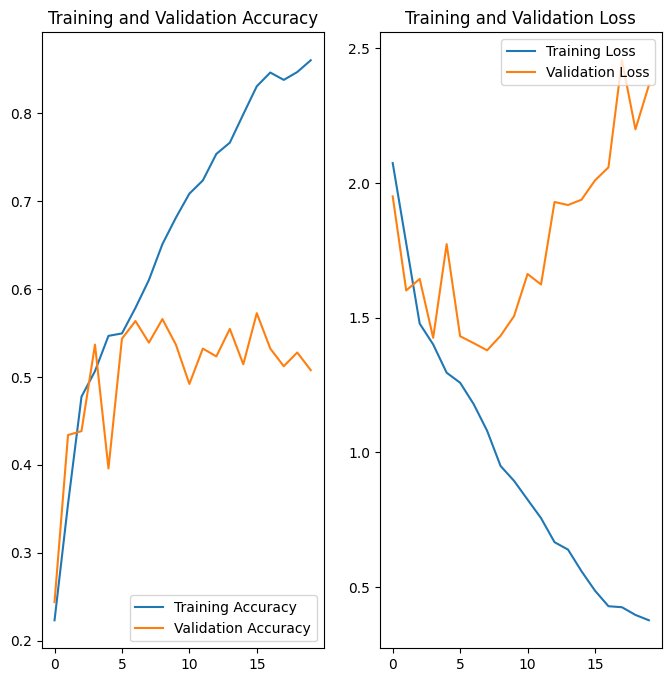

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit
### Finding on first base model
- From above chart we can see that the model is overfitting which is confirmed by the difference in loss functions in training & test from starting of 10-11th epoch

### Write your findings here

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip(mode='horizontal',
                                                     input_shape = (img_height, img_width, 3)),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
        layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode='reflect',interpolation='bilinear',seed=None,fill_value=0.0),
        layers.experimental.preprocessing.RandomCrop(img_height, img_width)
    ]
  )

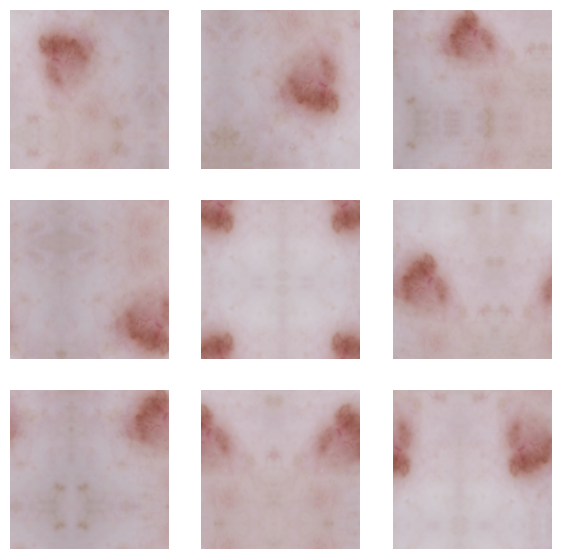

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(7,7))
for images,_ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    #plt.title(class_names[labels[0]])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_classes = 9
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256,3,padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_classes)

])


### Compiling the model

In [19]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 14s 145ms/step - loss: 2.1253 - accuracy: 0.2015 - val_loss: 2.0338 - val_accuracy: 0.1566
Epoch 2/20
56/56 [==============================] - 7s 117ms/step - loss: 1.9929 - accuracy: 0.2316 - val_loss: 1.8822 - val_accuracy: 0.2975
Epoch 3/20
56/56 [==============================] - 7s 120ms/step - loss: 1.8560 - accuracy: 0.2913 - val_loss: 1.7559 - val_accuracy: 0.3378
Epoch 4/20
56/56 [==============================] - 6s 115ms/step - loss: 1.7916 - accuracy: 0.3281 - val_loss: 1.6086 - val_accuracy: 0.3982
Epoch 5/20
56/56 [==============================] - 7s 121ms/step - loss: 1.6089 - accuracy: 0.4007 - val_loss: 1.6231 - val_accuracy: 0.3982
Epoch 6/20
56/56 [==============================] - 6s 112ms/step - loss: 1.5722 - accuracy: 0.3940 - val_loss: 1.7071 - val_accuracy: 0.4072
Epoch 7/20
56/56 [==============================] - 6s 111ms/step - loss: 1.6310 - accuracy: 0.3850 - val_loss: 1.6123 - val_accuracy: 0.4139
Epoch

### Visualizing the results

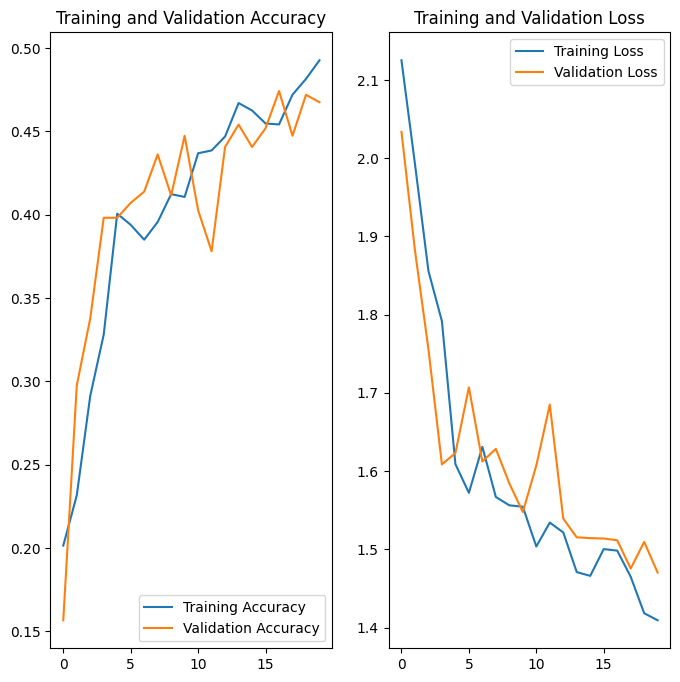

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Upgrad/ANN_assignment/...,actinic keratosis
1,/content/gdrive/MyDrive/Upgrad/ANN_assignment/...,actinic keratosis
2,/content/gdrive/MyDrive/Upgrad/ANN_assignment/...,actinic keratosis
3,/content/gdrive/MyDrive/Upgrad/ANN_assignment/...,actinic keratosis
4,/content/gdrive/MyDrive/Upgrad/ANN_assignment/...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Upgrad/ANN_assignment/...,vascular lesion
2235,/content/gdrive/MyDrive/Upgrad/ANN_assignment/...,vascular lesion
2236,/content/gdrive/MyDrive/Upgrad/ANN_assignment/...,vascular lesion
2237,/content/gdrive/MyDrive/Upgrad/ANN_assignment/...,vascular lesion


In [23]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Upgrad/ANN_assignment/...,actinic keratosis
1,/content/gdrive/MyDrive/Upgrad/ANN_assignment/...,actinic keratosis
2,/content/gdrive/MyDrive/Upgrad/ANN_assignment/...,actinic keratosis
3,/content/gdrive/MyDrive/Upgrad/ANN_assignment/...,actinic keratosis
4,/content/gdrive/MyDrive/Upgrad/ANN_assignment/...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Upgrad/ANN_assignment/...,vascular lesion
2235,/content/gdrive/MyDrive/Upgrad/ANN_assignment/...,vascular lesion
2236,/content/gdrive/MyDrive/Upgrad/ANN_assignment/...,vascular lesion
2237,/content/gdrive/MyDrive/Upgrad/ANN_assignment/...,vascular lesion


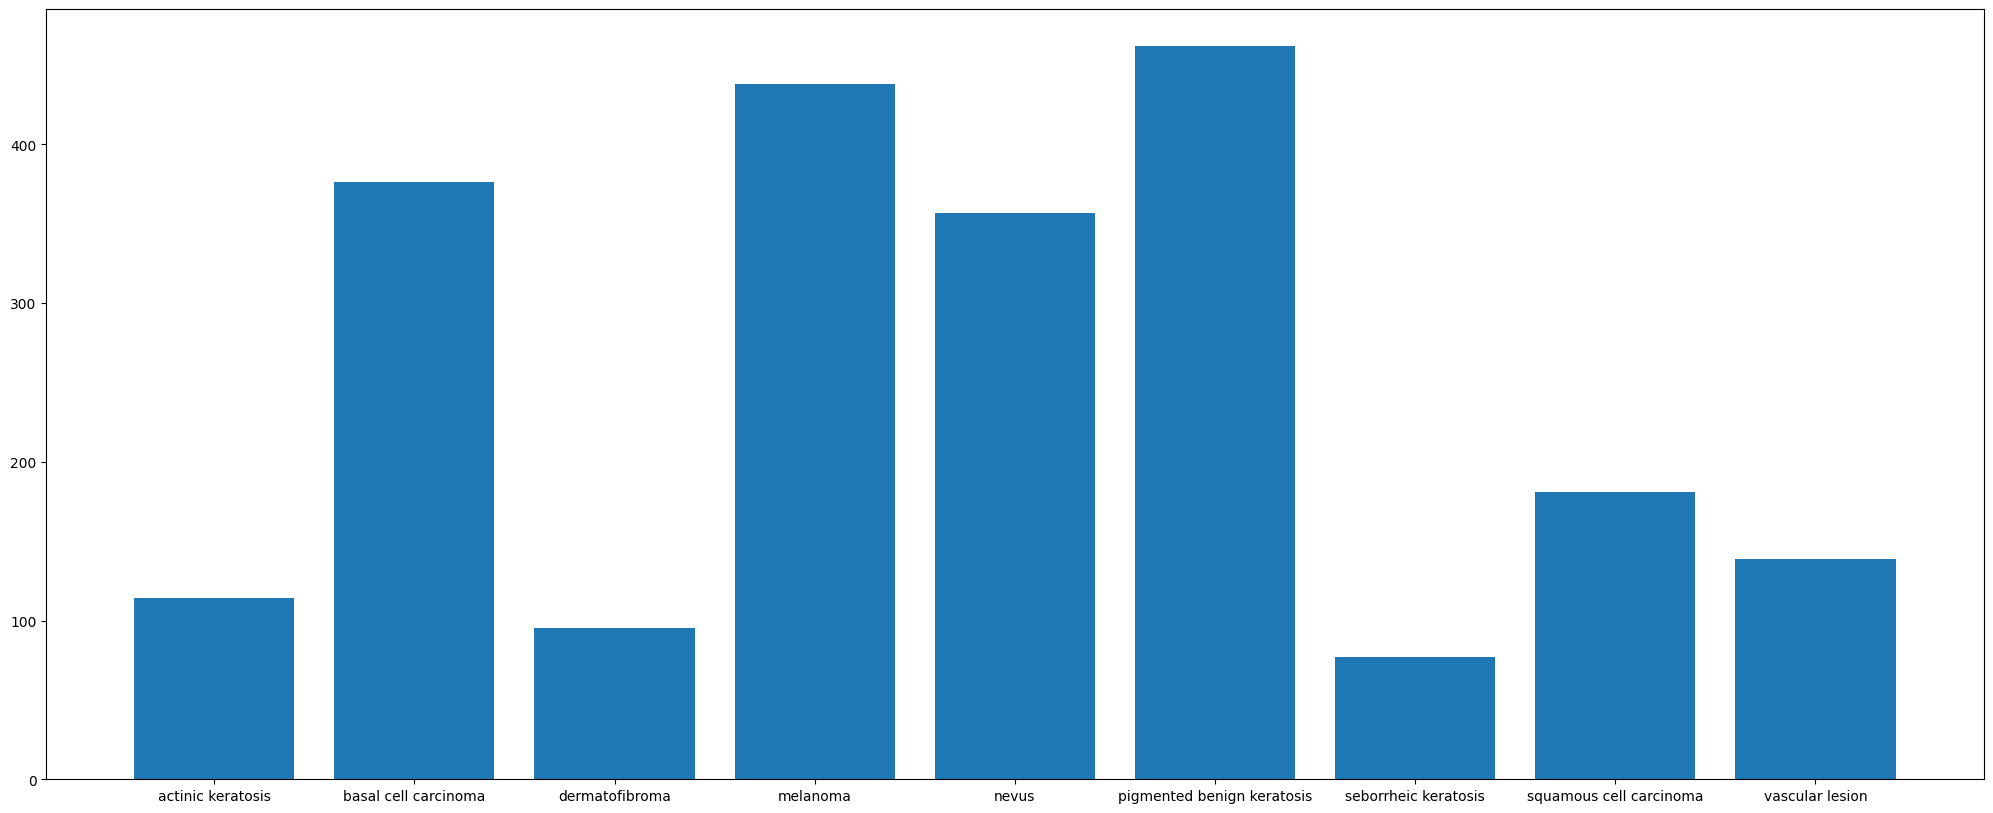

In [24]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)
plt.show()

#### **Todo:** Write your findings here:
#### Which class has the least number of samples?
- Bellow shared classes has least number of sample as compared to others
  - actinic Keratosis
  - dermatofibroma
  - seborrheic keratosis
  - squamous cell carcinoma
  - vascular lesion


#### Which classes dominate the data in terms proportionate number of samples?
- Bellow shared classes has least number of sample as compared to others
  - pigmented benign keratosis
  - melanoma

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
path_to_training_dataset="/content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x794E394923B0>: 100%|██████████| 500/500 [00:23<00:00, 21.41 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x794E394D3FA0>: 100%|██████████| 500/500 [00:21<00:00, 23.06 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x794E397DAEF0>: 100%|██████████| 500/500 [00:19<00:00, 25.16 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x794E39532590>: 100%|██████████| 500/500 [01:26<00:00,  5.77 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x794E44193910>: 100%|██████████| 500/500 [01:18<00:00,  6.36 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x794EA0167280>: 100%|██████████| 500/500 [00:17<00:00, 28.23 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x794E44191E70>: 100%|██████████| 500/500 [00:38<00:00, 13.08 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x794EBB6BB880>: 100%|██████████| 500/500 [00:18<00:00, 27.61 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x794EBB701540>: 100%|██████████| 500/500 [00:17<00:00, 27.88 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_1b3af35f-81cc-4f21-908f-9de6ad58db3f.jpg',
 '/content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030825.jpg_be284527-d5a8-4c65-b6e7-dc32b6dfd72c.jpg',
 '/content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_2ae77709-f273-4881-a690-a6c37d975938.jpg',
 '/content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026525.jpg_7d2bf178-52a2-483e-858b-77e25f2eae6c.jpg',
 '/content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin 

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [36]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [37]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-37-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [38]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [44]:
data_dir_train="/content/gdrive/MyDrive/Upgrad/ANN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [46]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [47]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [48]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 42s 79ms/step - loss: 1.8726 - accuracy: 0.2962 - val_loss: 1.5710 - val_accuracy: 0.3972
Epoch 2/30
169/169 [==============================] - 5s 28ms/step - loss: 1.4178 - accuracy: 0.4709 - val_loss: 1.3233 - val_accuracy: 0.5264
Epoch 3/30
169/169 [==============================] - 5s 31ms/step - loss: 1.2255 - accuracy: 0.5464 - val_loss: 1.4076 - val_accuracy: 0.4885
Epoch 4/30
169/169 [==============================] - 5s 28ms/step - loss: 1.0019 - accuracy: 0.6332 - val_loss: 1.0536 - val_accuracy: 0.6125
Epoch 5/30
169/169 [==============================] - 5s 31ms/step - loss: 0.7844 - accuracy: 0.7246 - val_loss: 0.9828 - val_accuracy: 0.6451
Epoch 6/30
169/169 [==============================] - 5s 28ms/step - loss: 0.6419 - accuracy: 0.7749 - val_loss: 0.7862 - val_accuracy: 0.7335
Epoch 7/30
169/169 [==============================] - 5s 29ms/step - loss: 0.4926 - accuracy: 0.8279 - val_loss: 0.7839 - val_accuracy: 0.755

#### **Todo:**  Visualize the model results

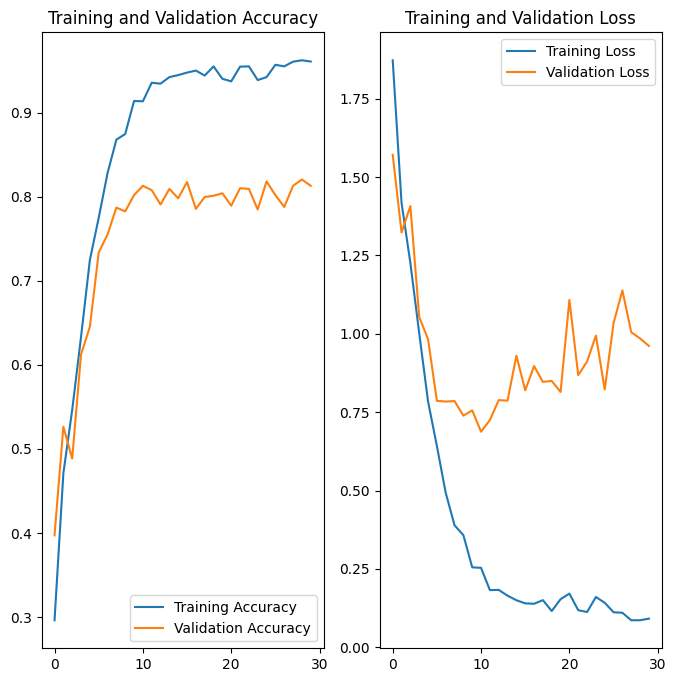

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- Accuracy on training data has increased by using Augmentor library

- Model is still overfitting, but better performing compared to before

- The problem of overfitting can be solved by add more layer,neurons.

- The Model can be further improved by tuning the hyperparameter